# Case study 3: The Escherichia coli K-12 transcriptional motif

In [5]:
!pip install git+https://github.com/y0-causal-inference/eliater.git

  Cloning https://github.com/y0-causal-inference/eliater.git to c:\users\pnava\appdata\local\temp\pip-req-build-ex_a_sac
  Resolved https://github.com/y0-causal-inference/eliater.git to commit 18c0c18d478251bae2c7ff6a1d0ac4997aed0dc4
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/y0-causal-inference/eliater.git 'C:\Users\pnava\AppData\Local\Temp\pip-req-build-ex_a_sac'

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


This is case study 3 in Figure 7 in this paper: *Eliater: an open source software for causal query estimation from observational measurements of biomolecular networks. The figure below shows the transcriptional regulatory network motif of E. coli from the EcoCyc database (Keseler et al., 2021). It comprises 44 nodes, of which 7 are latent and 45 are
observed, connected by a total of 147 directed edges.

In [6]:
import pandas as pd

from eliater.examples import ecoli_transcription_example

In [7]:
graph = ecoli_transcription_example.graph

The observational data are 260 RNA-seq normalized expression profiles of E. coli K-12 MG1655 and BW25113 strains, spanning 154 distinct experimental conditions. These data were retrieved from the PRECISE database (Sastry et al., 2019).

In [8]:
# Get the data
# TODO: Change from local path to Github url
data = pd.read_csv(
    "C:\\Users\\pnava\\PycharmProjects\\eliater\\src\\eliater\\data\\EColi_obs_data.csv",
    index_col=0,
)

In [9]:
data.head()

,cra,aceE,phoB,cyoA,amtB,appY,citC,dpiB,dpiA,fur,...,mdh,fis,crp,rpoH,gadX,cspA,oxyR,soxS,dcuR,arcA
1,7.697991,10.651307,5.599989,11.254009,5.128441,5.919468,0.000000,4.323397,4.761679,9.737595,...,11.745289,8.936196,9.666416,8.725102,8.614542,7.743336,8.209081,6.230069,5.752131,9.547993
2,7.581105,10.761484,5.746619,11.431429,5.614179,5.628823,0.000000,4.706430,4.930888,9.784892,...,11.843169,8.601549,9.621358,8.769579,8.456629,7.474558,8.417561,6.104497,5.667736,9.560289
3,6.395808,12.109947,6.009650,9.937863,3.866721,5.789442,0.000000,4.776288,5.291245,9.381882,...,11.166194,7.013285,9.761605,9.649581,8.391347,3.629759,7.841489,8.009047,5.725878,10.737478
4,6.366865,11.992996,6.131477,9.838573,3.666917,5.496674,0.377771,4.659630,5.366084,9.468696,...,11.030617,7.078497,9.706964,9.746059,8.180204,4.538549,7.754378,8.172509,5.470773,10.788613
5,7.315204,10.569824,5.158324,11.272986,6.146377,5.275278,0.190837,4.332369,4.786446,9.779253,...,11.423517,9.878379,9.692445,8.226875,8.142990,7.147757,7.979421,6.161353,5.738662,9.470079


## Step 1: Verify correctness of the network structure

The total number of d-separations implied by this network is large. It takes several hours to find all of them and test them against data. On the other hand, High-dimensional conditional independence tests can be very unreliable. Hence, it is best to control number of variables to condition upon. Here we selected 3. However, the default in this function is 5. Even with max_given equal to 3, it takes around an hour to produce the results.

In [10]:
from eliater.network_validation import print_graph_falsifications

In [ ]:
# Took 30 minutes to run
print_graph_falsifications(
    graph, data, max_given=3, method="pearson", verbose=True, significance_level=0.01
)

## Step 2: Check query identifiability

In [12]:
from y0.algorithm.identify import Identification
from y0.dsl import P, Variable

id_in = Identification.from_expression(
    query=P(Variable("dpiA") @ Variable("fur")),
    graph=graph,
)
id_in

Identification(outcomes="{dpiA}, treatments="{fur}",conditions="set()",  graph="NxMixedGraph(directed=<networkx.classes.digraph.DiGraph object at 0x00000236281DBD50>, undirected=<networkx.classes.graph.Graph object at 0x00000236281DA6D0>)", estimand="P(aceE, amtB, appA, appB, appY, arcA, aspC, btsR, cirA, citC, cra, crp, cspA, cydD, cyoA, dcuR, dpiA, dpiB, exuT, fis, fnr, fur, gadX, gutM, hcp, hns, hyaA, hyaB, hyaF, ihfA, ihfB, iscR, lrp, mdh, modE, narL, narP, oxyR, phoB, rpoD, rpoH, rpoS, soxS, ydeO)")

The query is identifiable. Hence, we can proceed to the next step.

## Step 3: Find nuisance variables and mark them as latent

This function finds the nuisance variables for the input graph.

In [13]:
from eliater.discover_latent_nodes import find_nuisance_variables

In [14]:
nuisance_variables = find_nuisance_variables(
    graph, treatments=Variable("fur"), outcomes=Variable("dpiA")
)
len(nuisance_variables)

21

A total of 21 nodes are found as nuisance variables.

In [15]:
# get the list of nuisance variables
nuisance_variables

{aceE,
 amtB,
 appA,
 appB,
 appY,
 aspC,
 cirA,
 citC,
 cydD,
 cyoA,
 dpiB,
 exuT,
 gadX,
 gutM,
 hcp,
 hns,
 hyaA,
 hyaB,
 hyaF,
 mdh,
 ydeO}

## Step 4: Simplify the network

The following function find the nuisance variable (step 3), marks them as latent and then applies Evan's simplification rules to remove the nuisance variables.

In [16]:
from eliater.discover_latent_nodes import remove_nuisance_variables

In [17]:
new_graph = remove_nuisance_variables(graph, treatments=Variable("fur"), outcomes=Variable("dpiA"))

## Step 5: Estimate the query

In [18]:
from eliater.regression import (
    estimate_query,
    summary_statistics,
    fit_regression,
)

In [19]:
fit_regression(new_graph, data, treatments=Variable("fur"), outcome=Variable("dpiA"))

RegressionResult(coefficients={arcA: 0.12950445828726914, crp: 0.2071315157858144, fur: 0.0454156792894872, rpoD: 0.10670663838046318, rpoS: 0.15282173840052252}, intercept=-1.5922857335185867)

In [20]:
estimate_query(
    new_graph,
    data,
    treatments=Variable("fur"),
    outcome=Variable("dpiA"),
    interventions={Variable("fur"): 0},
    query_type="expected_value",
)

4.413484796736575

The estimated value for the query E[dpiA | fur = 0] is 4.41. This shows that perturbation of gene fur has an increasing effect on gene dpiA.

In [22]:
summary_statistics(
    new_graph,
    data,
    treatments=Variable("fur"),
    outcome=Variable("dpiA"),
    interventions={Variable("fur"): 0},
)

SummaryStatistics(size=258.0, mean=4.413484796736575, std=0.20700013183231403, min=3.977629908827109, first_quartile=4.254331144148171, second_quartile=4.4255417772261385, third_quartile=4.568106337515038, max=4.973350664463695)

The summary statistics provides more details regarding the query in the form of P(dpiA | fur=0). This result can be used to generate box plots that shows the estimated distribution of dpiA given a perturbation on fur.

## Evaluation criterion
The PRECISE database that the observational data was retrieved from included an interventional experiment with the value of fur set to zero, and three biological replicates. Hence, the ground truth for the query E[dpiA | fur = 0] was the mean expression of dpiA over the three replicates, resulted in 4.9.

The estimated value for the query (4.41) is close in sign and magnitude to the
value of 4.9 obtained from the experimental interventional data.

In [24]:
import seaborn as sns

[Text(0.5, 0, 'Probability'),
 Text(0.5, 1.0, 'Estimated outcome probability distribution')]

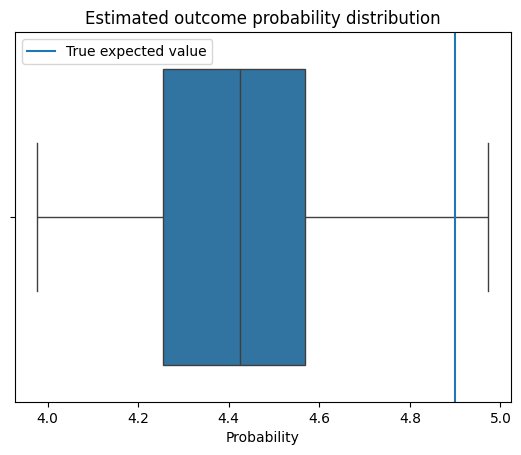

In [34]:
x = estimate_query(
    new_graph,
    data,
    treatments=Variable("fur"),
    outcome=Variable("dpiA"),
    interventions={Variable("fur"): 0},
    query_type="probability",
)
ax = sns.boxplot(x=x)
ax.axvline(x=4.9, label="True expected value")
ax.legend()
ax.set(xlabel="Probability", title="Estimated outcome probability distribution")